In [2]:
import numpy as np
import igraph
import networkx as nx
from pulser import channels

import matplotlib.pyplot as plt

from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2

from scipy.optimize import minimize
import warnings

from pulser_simulation import Simulation
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform


# Intro

In this tutorial, we illustrate how to solve the Maximum Independent Set (MIS) problem using the Quantum Approximate Optimization Algorithm procedure on a platform of Rydberg atoms in analog mode, using Pasqal's library Pulser.

For more info: [Pichler, et al., https://arxiv.org/abs/1808.10816, Henriet, https://journals.aps.org/pra/abstract/10.1103/PhysRevA.101.012335 and Dalyac, et al., https://arxiv.org/abs/2012.14859].

Consider an undirected graph composed of a set of vertices connected by unweighted edges. An independent set of this graph is a subset of vertices where any two elements of this subset are not connected by an edge. The Maximum Independent Set (MIS) corresponds to the largest of such subsets, and it is in general an NP-complete problem to determine the MIS of a graph. 

The MIS problem has several interesting applications, such as portfolio diversification in
finance, or broadcast systems (wifi or cellular network) optimization.

For example, assume an ensemble of identical radio transmitters over French cities that each have the same radius of transmission. It was quickly realized that two transmitters with close or equal frequencies could interfere with one another, hence the necessity to assign non-interfering frequencies to overlapping transmiting towers. 

Because of the limited amount of bandwith space, some towers have to be assigned the same or close frequencies. 

The MIS of a graph of towers indicate the maximum number of towers that can have close or equal given frequency (red points).

<img src="files/France_MIS.png" alt="MIS map France" style="width: 700px;"/>


When looking for the MIS of a graph, we separate the nodes into two distinct classes: an independence one and the others. We can attribute a status $z$ to each node, where $z_i = 1$  if node $i$ is attributed to the independent set, and $z_i=0$ otherwise. 

The Maximum Independent Set corresponds to  the minima of the following cost function: 

\begin{equation}
   C(z_1,\dots,z_N) = -\sum_{i=1}^N z_i + U \sum_{\langle i,j \rangle}z_i z_j
 \label{cost_function}
\end{equation}

where $U \gg 1$  and $\langle i,j \rangle$ represents adjacent nodes (i.e. there is a link between node $i$ and $j$). In this cost function, we want to promote a maximal number of atoms to the $1$ state, but the fact that $U \gg 1$  strongly penalizes two adjacent vertices in state $1$. The minimum of $C(z_0,\dots,z_N)$ therefore corresponds to the maximum independent set of the graph.

Interestingly, the operator $\hat{C}$ associated with the cost function of the previous equation can be natively realized on a neutral atom platform with some constraints on the graph edges. We map a  ground state and a Rydberg state of each atom to a two-level system, where $|1 \rangle = |r \rangle$ is a Rydberg state and $|0 \rangle = |g \rangle$ is a ground state. 

Placing $N$ atoms at positions $\textbf{r}_j$ in a 2D plane, and coupling the ground state $|0\rangle$ to the Rydberg state $|1\rangle$ with a laser system enables the realization of the Hamiltonian :

$$
H= \sum_{i=1}^N \frac{\hbar\Omega}{2} \sigma_i^x - \sum_{i=1}^N \frac{\hbar \delta}{2}  \sigma_i^z+\sum_{j<i}\frac{C_6}{|\textbf{r}_i-\textbf{r}_j|^{6}} n_i n_j.
\label{eq:ising_Hamiltonian}
$$

Here, $\Omega$ and $\delta$ are respectively the Rabi frequency and detuning of the laser system and $\hbar$ is the reduced Planck constant. 

The first two terms of the equation govern the transition between states $|0\rangle$ and $|1 \rangle$ induced by the laser, while the third term represents the repulsive Van der Waals interaction between atoms in the $|0\rangle$ state. More precisely, $n_i = \frac 12 (\sigma_i^z + 1)$ counts the number of Rydberg excitations at position $i$. The interaction strength between two atoms decays as $|\textbf{r}_i-\textbf{r}_j|^{-6}$.





### From a graph to an atomic register

We now illustrate how one can use Pulser and a Pasqal device to find the MIS of a UD-graph. Because the quantum platform is emulated in this notebook, we restrict the number of atoms to 5, just to show a proof-of-concept.

In [3]:
#This function takes in input the position of qubits and creates the graph connecting
# qubits whose distance is less thanthe  rydberg blockade radius (a.k.a. rbr)

# qubit synonim of  atoms / nodes of the graph / cities where there is the antenna

def pos_to_graph(pos, d = Chadoq2.rydberg_blockade_radius(1)): #d è il  rbr
    g=igraph.Graph()
    edges=[]
    for n in range(len(pos)-1):
        for m in range(n+1, len(pos)):
            pwd = ((pos[m][0]-pos[n][0])**2+(pos[m][1]-pos[n][1])**2)**0.5
            if pwd < d:
                edges.append([n,m])                 # Within rbr, nodes are connected
    g.add_vertices(len(pos))
    g.add_edges(edges)
    return g

Here, we create an atomic register with 5 atoms and graph using the  "pos_to_graph" function

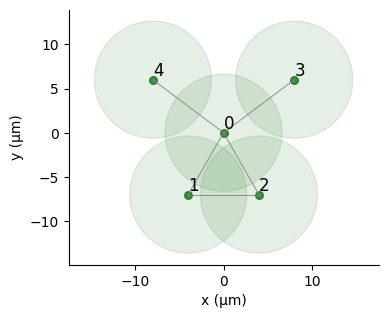

In [4]:
#Initial position of qubits
pos = np.array([[0., 0.], [-4, -7], [4,-7], [8,6],[-8,6]])
#Creation of the graph
G = pos_to_graph(pos) 

#create register and visualize
qubits = dict(enumerate(pos))
reg = Register(qubits)
reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
)

This graph has two MIS: $(1,3,4)$ e $(2,3,4)$
Since the ordering of the vertices is (0,1,2,3,4), the two configuartions become in binary:

$(1,3,4)$= $'01011'$

$(2,3,4)$=$'00111'$


# 2 QAOA for MIS

Now, we must build the quantum part of the QAOA. All atoms are initially in the groundstate $|00\dots0\rangle$.

We then apply $p$ layers of alternating non-commutative Hamiltonians.

The first one, called the mixing Hamiltonian $H_B$, is realized by taking Rabi frequency$\Omega = 1$ MHz,  and a detuning  $\delta = 0 $ MHz in the Hamiltonian equation.


\begin{equation}
    H_B= \sum_{i=1}^N \frac{\hbar}{2} \sigma_i^x 
\label{eq:ising_Hamiltonian}
\end{equation}



The second Hamiltonian (associated to the MIS) $H_c$ is realized with $\Omega =0$ and $ \delta = 1$ MHz. $

\begin{equation}
    H_c=  - \sum_{i=1}^N \frac{\hbar }{2}  \sigma_i^z +\sum_{j<i}\frac{C_6}{|\textbf{r}_i-\textbf{r}_j|^{6}} n_i n_j.
\label{eq:ising_Hamiltonian}
\end{equation}

$H_B$ and $H_c$ are applied turn in turn with parameters $\tau$ and $t$ respectively. 

A classical optimizer is then used to estimate the optimal parameters. 


In [5]:
LAYERS = 2

# Parametrized sequence

#initialize the sequence giving as input the register of qubit r and the device Chadoq2
seq = Sequence(reg, Chadoq2)
#declare the channels: we use  ch0 and  rydberg_global
seq.declare_channel("ch0", "rydberg_global")

#defines the parameters associated to the two pulses
t_list = seq.declare_variable("t_list", size=LAYERS)
s_list = seq.declare_variable("s_list", size=LAYERS)

#applies the two pulses H_B e H_c alternating them
for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
    pulse_2 = Pulse.ConstantPulse(1000 * s, 0.0, 1.0, 0)

    seq.add(pulse_1, "ch0")
    seq.add(pulse_2, "ch0")

seq.measure("ground-rydberg")

In [6]:
#Define the  quantum loop of QAOA 
def quantum_loop(parameters):
    
    params = np.array(parameters)
    
    t_params, s_params = np.reshape(params.astype(int), (2, LAYERS))
    
    assigned_seq = seq.build(t_list=t_params, s_list=s_params)
    #print("sequence")
    #print(assigned_seq)
    #print()
    
    simul = Simulation(assigned_seq, sampling_rate=0.01)
    
    results = simul.run()
    
    count_dict = results.sample_final_state()  # sample from the state vector
    #print ("count_dict")
    #print (count_dict)
    #print()
    return count_dict

In [7]:
np.random.seed(1)  # ensures reproducibility of the tutorial
guess = {
    "t": np.random.uniform(8, 10, LAYERS),
    "s": np.random.uniform(1, 3, LAYERS),
}


In [8]:
example_dict = quantum_loop(np.r_[guess["t"], guess["s"]])


We can then plot the distribution of the samples, to see the most frequent bitstrings sampled.

In [9]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    color_dict = {key: 'g' for key in C}
    indexes = ['01011', '00111']  # MIS indexes
    for i in indexes: 
        color_dict[i] = 'red'
    plt.figure(figsize=(12,6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color = color_dict.values())
    plt.xticks(rotation='vertical')
    plt.show()

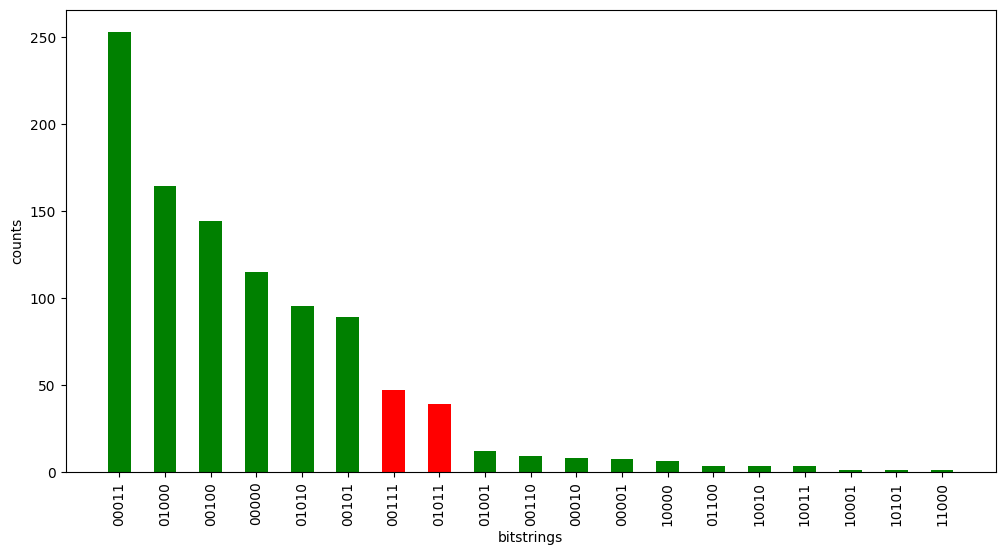

In [10]:
plot_distribution(example_dict)

# Optimization

We estimate the cost of a sampled state vector.   The average estimate is then used in the classical loop to optimize the variational parameters $\tau$ and $t$.

In [11]:
def get_cost_colouring(bitstring, G):
    cost = 0 
    A = G.get_adjacency()
    z=bitstring
    z = np.array(tuple(z),dtype=int)
    for i in range(len(z)):
        for j in range(i,len(z)):
            cost += A[i][j]*z[i]*z[j]*10 # if there's an edge between i,j and they are both in |1> state.
    
    cost -= np.sum(z) #to count for the 0s instead of the 1s 
    return cost 


def get_cost(counter, G):
    cost = sum(counter[key] * get_cost_colouring(key, G) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

In [12]:
get_cost_colouring('00001', G)

-1

In [13]:
#func puts together the quantum part i.e. quantum_loop and the classical evaluation of the cost

def func(param, *args):
    G = args[0]
    C = quantum_loop(param)
    cost = get_cost(C, G)
    return cost

## QAOA for depth p = 2 (2  repetitions)

We now use a classical optimizer `minimize` in order to find the best variational parameters. This function takes as arguments `func`, the graph `G`and an initial `x0` point for the minimization.

In [14]:
scores = []
params = []
for repetition in range(10):
    guess = {
        "t": np.random.uniform(1, 10, LAYERS),
        "s": np.random.uniform(1, 10, LAYERS),
    }
    #print(repetition)
    print("rep=",repetition+1, "guess= ", guess)
    #print()

    try:
        res = minimize(
            func,
            args=G,
            x0=np.r_[guess["t"], guess["s"]],
            method="Nelder-Mead",
            tol=1e-5,
            options={"maxiter": 10},
        )
        scores.append(res.fun)
        params.append(res.x)
        
    except Exception as e:
        pass

rep= 1 guess=  {'t': array([1.1645945 , 7.75129883]), 's': array([9.8997498 , 7.73349089])}
rep= 2 guess=  {'t': array([2.61814868, 3.89637967]), 's': array([2.55344158, 4.67773503])}
rep= 3 guess=  {'t': array([9.1639815 , 8.74411001]), 's': array([4.04606246, 1.24442946])}
rep= 4 guess=  {'t': array([4.53663912, 9.90506918]), 's': array([5.63693227, 5.30941061])}
rep= 5 guess=  {'t': array([9.565982  , 6.06502495]), 's': array([7.1969968 , 1.23713091])}
rep= 6 guess=  {'t': array([7.16895977, 5.13204778]), 's': array([6.16107009, 6.16653489])}
rep= 7 guess=  {'t': array([3.59482118, 1.95414952]), 's': array([7.20514199, 7.74507264])}
rep= 8 guess=  {'t': array([6.68444314, 4.92996605]), 's': array([3.77062308, 2.86940142])}
rep= 9 guess=  {'t': array([7.90020436, 1.1734161 ]), 's': array([9.46898429, 8.52300588])}
rep= 10 guess=  {'t': array([8.54596037, 3.74340243]), 's': array([4.17787937, 7.57577216])}


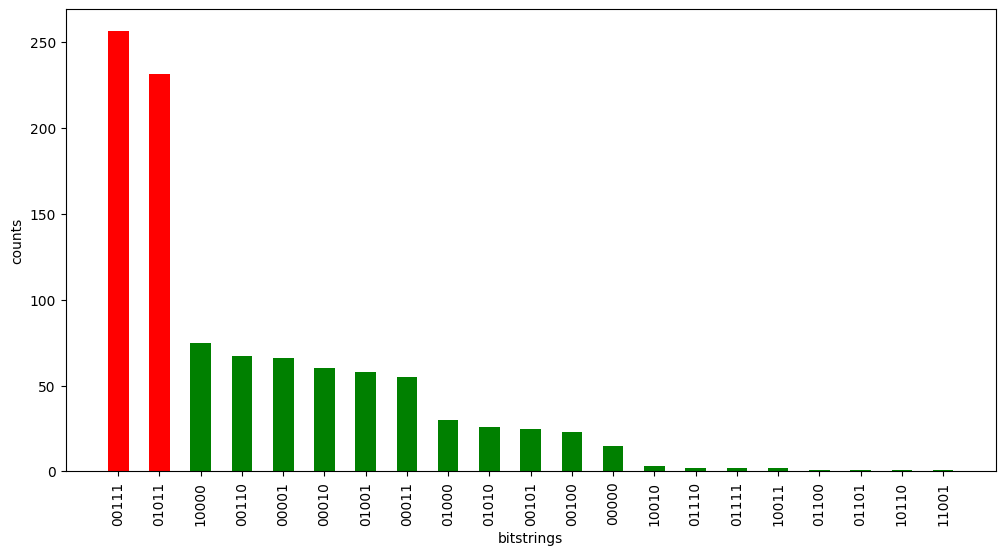

In [21]:
optimal_count_dict = quantum_loop(params[np.argmin(scores)])
plot_distribution(optimal_count_dict)

QAOA is capable of finding good variational parameters $\tau$ and $t$. Now, sampling from this final state $\psi_{f}$ will return both MISs of the graph with high probability. Note that listing all maximal independent sets of a graph is also NP, and can be used as a subroutine for solving many NP-complete graph problems. 

In [22]:
Chadoq2.interaction_coeff 


5420158.53